Synthetic Dataset Preview:
    events_nearby  temperature  population_density  day_Monday  day_Saturday  \
0              0           16                  50       False         False   
1              0           15                  72       False         False   
2              1           31                  32       False         False   
3              0           30                 113       False         False   
4              0           19                  84       False         False   

   day_Sunday  day_Thursday  day_Tuesday  day_Wednesday  time_Evening  \
0        True         False        False          False          True   
1       False          True        False          False         False   
2       False         False        False          False          True   
3        True         False        False          False         False   
4       False         False        False           True         False   

   time_Morning  time_Night  
0         False       False 

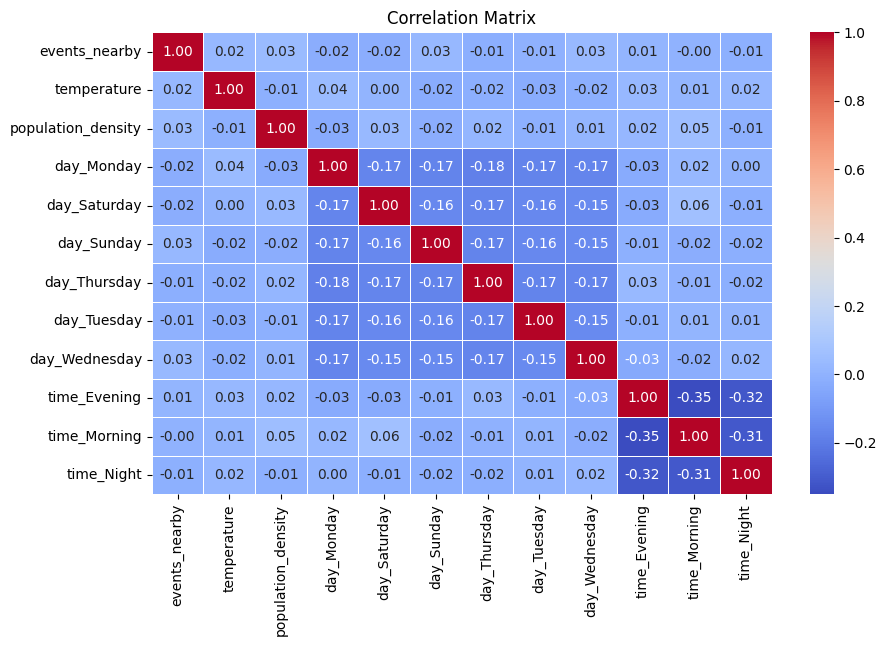

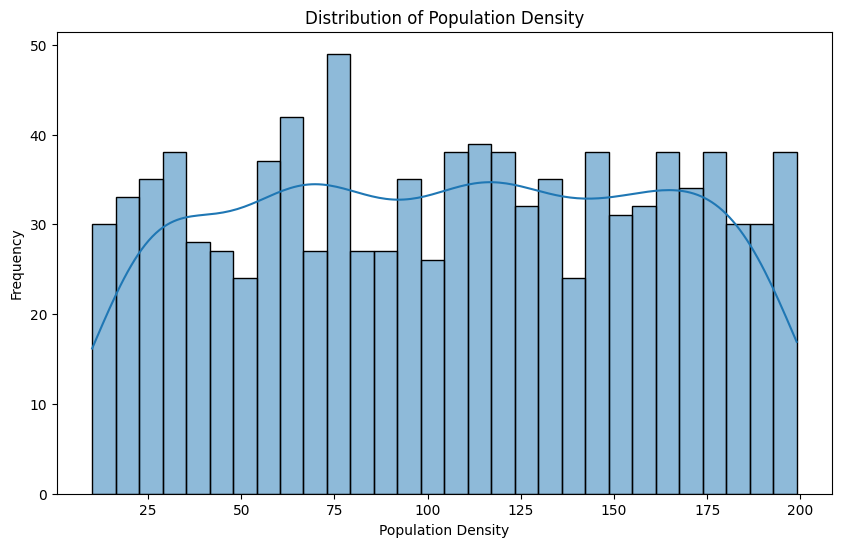

<ipython-input-1-c49e9598873d>:72: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='day_Monday', y='population_density', data=df, ci=None)


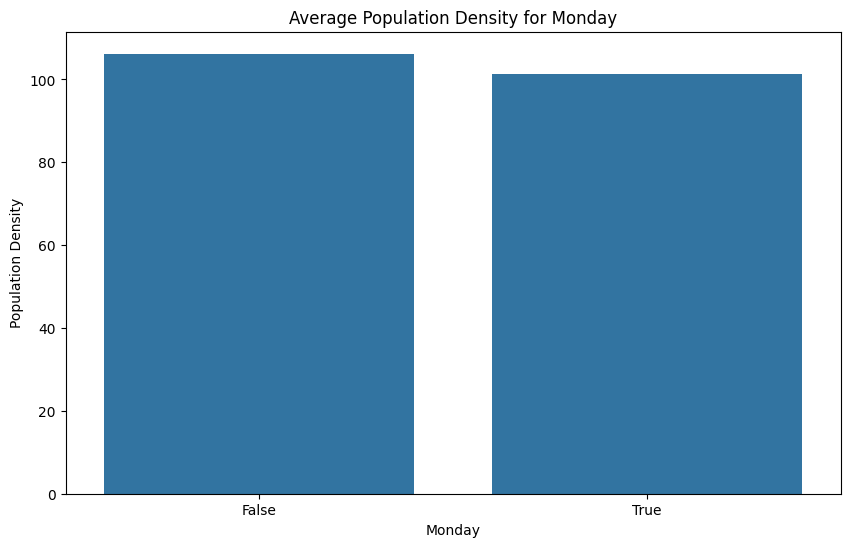

Predicted population density for Friday Afternoon with events nearby: 1 and temperature 25°C is 159.48 people


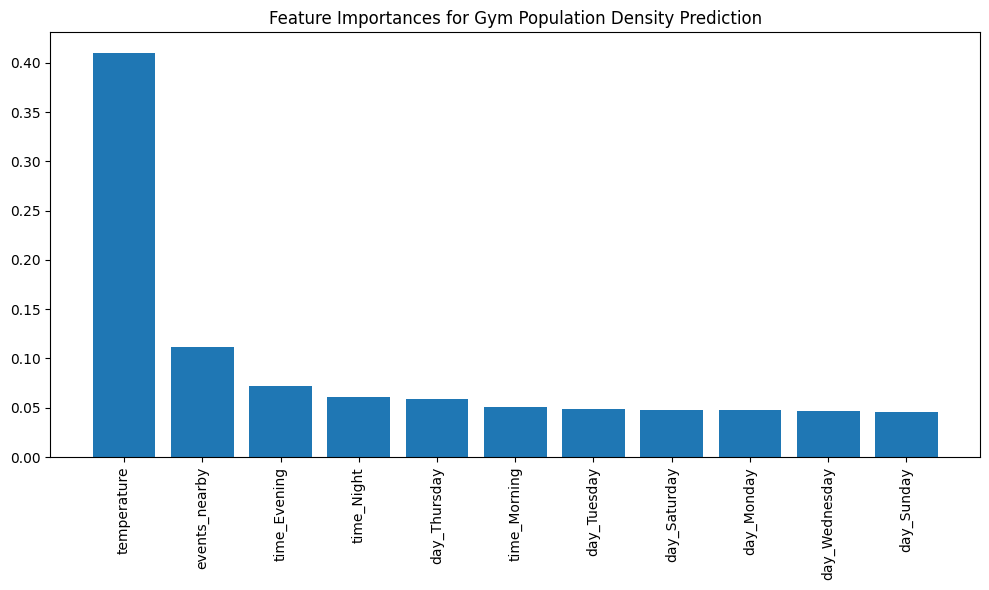

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Generate Synthetic Data (Including the new features)
np.random.seed(42)

# Define possible days and times for synthetic data
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
times = ['Morning', 'Afternoon', 'Evening', 'Night']

# Generate a synthetic dataset of 1000 entries
data = {
    'day': np.random.choice(days, 1000),
    'time': np.random.choice(times, 1000),
    'events_nearby': np.random.choice([0, 1], 1000),  # 0 = no event, 1 = event nearby
    'temperature': np.random.randint(15, 35, 1000),   # temperature in Celsius
    'population_density': np.random.randint(10, 200, 1000)  # gym population density
}

# Convert data into a DataFrame
df = pd.DataFrame(data)

# Encode categorical features (day and time)
df = pd.get_dummies(df, columns=['day', 'time'], drop_first=True)

# Display the first few rows of the synthetic dataset
print("Synthetic Dataset Preview:\n", df.head())

# Step 2: Train a Machine Learning Model

# Split data into features and target
X = df.drop('population_density', axis=1)
y = df['population_density']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

# Step 3: Data Visualization

# Visualizing the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Visualizing population density distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['population_density'], kde=True, bins=30)
plt.title("Distribution of Population Density")
plt.xlabel("Population Density")
plt.ylabel("Frequency")
plt.show()

# Visualize the population density by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x='day_Monday', y='population_density', data=df, ci=None)
plt.title('Average Population Density for Monday')
plt.ylabel('Population Density')
plt.xlabel('Monday')
plt.show()

# Step 4: Use the Model for Prediction

# Helper function to align input features with training features
def align_features(input_df, model_features):
    # Ensure all model feature columns exist in the input
    for feature in model_features:
        if feature not in input_df.columns:
            input_df[feature] = 0
    # Drop any extra columns
    input_df = input_df[model_features]
    return input_df

# Function to predict gym population density for a specific day, time, and conditions
def predict_density(day, time, events_nearby, temperature):
    # Create a dictionary for input data
    input_data = {
        'events_nearby': [events_nearby],
        'temperature': [temperature],
        **{f'day_{d}': [1 if d == day else 0] for d in days[1:]},  # One-hot encode day
        **{f'time_{t}': [1 if t == time else 0] for t in times[1:]}  # One-hot encode time
    }

    # Convert to DataFrame
    input_df = pd.DataFrame(input_data)

    # Align input features to match model training features
    input_df_aligned = align_features(input_df, X.columns)

    # Predict and return the population density
    predicted_density = model.predict(input_df_aligned)[0]
    return predicted_density

# Example usage for prediction
day = "Friday"
time = "Afternoon"
events_nearby = 1  # 1 if there's a nearby event, 0 if not
temperature = 25   # Temperature in Celsius

predicted_density = predict_density(day, time, events_nearby, temperature)
print(f"Predicted population density for {day} {time} with events nearby: {events_nearby} and temperature {temperature}°C is {predicted_density:.2f} people")

# Optional: Plot feature importance to understand impact of each feature
importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances for Gym Population Density Prediction")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()